# Sub Class 모델링

모델 이란 것은 Input을 Output으로 만들어주는 수식이다. 

해당 기능을 수행하는 두 가지 클래스가 `tf.keras.layers.Layer` 와 `tf.keras.layers.Model` 클래스이다. 

두가지 모두 **연산을 추상화** 하는 것으로 동일한 역할을 하지만, `tf.keras.layers.Model` 클래스의 경우 모델을 저장 하는 기능 과 `fit` 함수를 사용할 수 있다는 점에서 차이가 있다. 

- tf.keras.layers.Layer
- tf.keras.layers.Model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

### Linear Regression을 Layer로 만들어 보자. 

In [3]:
class LinearRegression(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LinearRegression, self).__init__()
        self.units = units # output 개수

    def build(self, input_shape): # 변수를 받는 오버라이딩 
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal", # 어느 분포에서 random하게 추출할 것인지 설정
            trainable=True,
        )
        self.b = tf.Variable(0.0) # 위와 같이 만들어도 되고 이 문장과 같이 만들어도 됨

    def call(self, inputs): # 출력을 해줄 값을 지정하는 오버라이딩
        return tf.matmul(inputs, self.w) + self.b

### 가상 데이터

In [4]:
# 정답
W_true = np.array([[3., 2., 4., 1.]]).reshape((4, 1))
B_true = np.array([1.]) 

X = tf.random.normal((500, 4))
noise = tf.random.normal((500, 1))

y = X @ W_true + B_true + noise

In [5]:
opt = tf.keras.optimizers.SGD(learning_rate=0.03)


linear_layer = LinearRegression(1)

for epoch in range(100):
    with tf.GradientTape() as tape:
        y_hat = linear_layer(X)
        loss = tf.reduce_mean(tf.square((y - y_hat)))
        
    grads = tape.gradient(loss, linear_layer.trainable_weights)
    # assign 대신 업데이트하는 방식
    opt.apply_gradients(zip(grads, linear_layer.trainable_weights))
    
    if epoch % 10 == 0:
        print("epoch : {} loss : {}".format(epoch, loss.numpy()))

epoch : 0 loss : 33.26325607299805
epoch : 10 loss : 9.79842758178711
epoch : 20 loss : 3.352088451385498
epoch : 30 loss : 1.5760014057159424
epoch : 40 loss : 1.0850523710250854
epoch : 50 loss : 0.9488410353660583
epoch : 60 loss : 0.9108928442001343
epoch : 70 loss : 0.9002712368965149
epoch : 80 loss : 0.8972828984260559
epoch : 90 loss : 0.8964372277259827


In [6]:
linear_layer(X[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7254715]], dtype=float32)>

### ResNet - Sub Class 로 구현 하기 

1. Residual Block(반복되는 코드) - Layer
2. ResNet  - Model

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [8]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters=32, filter_match=False):
        super(ResidualBlock, self).__init__()
    
        # 필요한 레이어들 받아오기
        self.conv1 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        self.conv3 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')
        self.add = Add()
        
        self.filters = filters
        self.filter_match = filter_match

        # 첫번째 step에서 filter 개수가 맞지 않아
        # 한 번 Conv2D를 다시 64로 생성하여 input과 output을 add해준 적이 있다.
        # 그 부분을 조건문으로 처리하면 아래와 같다.
        if filter_match:
            self.conv_ext = Conv2D(filters, kernel_size=1, padding='same')
        
    def call(self, inputs):
        net1 = self.conv1(inputs)
        net2 = self.conv2(net1)
        net3 = self.conv3(net2)
        
        if self.filter_match:
            res = self.add([self.conv_ext(inputs), net3])
        else: 
            res = self.add([inputs, net3])
        return res 
        
        

In [9]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')
        self.maxp1 =  MaxPool2D()
        self.block_1 = ResidualBlock(64, True)
        self.block_2 = ResidualBlock(64)
        self.maxp2 =  MaxPool2D()
        self.flat = Flatten()
        self.dense = Dense(num_classes)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxp1(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.maxp2(x)
        x = self.flat(x)
        return self.dense(x)

model = ResNet(num_classes=10)

### 학습 시켜보기

In [10]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [11]:
cifar10_loader = Cifar10DataLoader()

train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [12]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [13]:
hist = model.fit(train_x, train_y,
                 epochs=2, batch_size=128,
                 validation_data=(test_x, test_y))

Epoch 1/2
391/391 [==============================] - 22s 53ms/step - loss: 2.3131 - accuracy: 0.0617 - val_loss: 2.2512 - val_accuracy: 0.0412
Epoch 2/2
391/391 [==============================] - 22s 57ms/step - loss: 2.2770 - accuracy: 0.0470 - val_loss: 2.2373 - val_accuracy: 0.0506


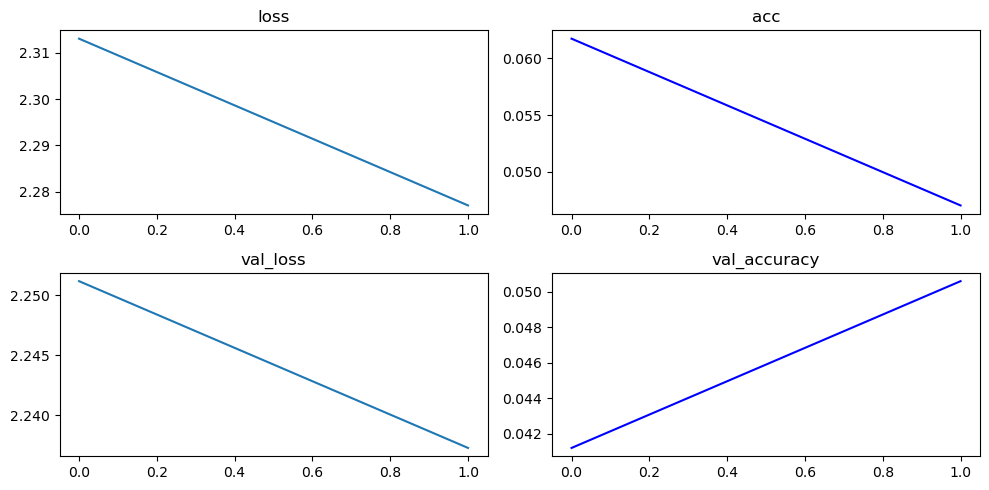

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()